# Climate Solution Notebook

In [108]:
# Denpendencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime as dt

# ignore version warning
from warnings import filterwarnings
filterwarnings('ignore')

## Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, or_

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [14]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Precipitation Analysis

In [115]:
# Find the most recent date in the data set.
most_recent_date = (
    session.query(Measurements.date)
    # .order_by(Measurements.date)
    .order_by(Measurements.date.desc())
    .limit(1)
    # Use the `.scalar()` method to execute the query and get a single result. This will return a single value from the first column of the query.
    .scalar()
)
print(most_recent_date)

2017-08-23


<Figure size 1200x1000 with 0 Axes>

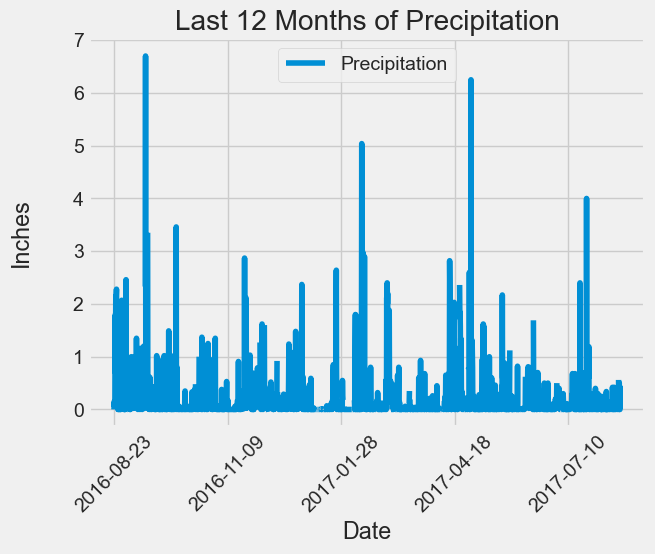

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the last date in data set.
previous_date = (
    (most_recent_date - dt.timedelta(days=365))   # Calculate the date
    .strftime('%Y-%m-%d')  # Format
)
# previous_date
# Perform a query to retrieve the data and precipitation scores
prcp_data = (
    session.query(Measurements.date, Measurements.prcp)
    .filter(and_(Measurements.date >= previous_date,
                 Measurements.date <= most_recent_date))
    .order_by(Measurements.date)
    .all()
)
## Display and review
# print(prcp_data)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = (
    pd.DataFrame(prcp_data, columns=['date', 'precipitation'])
    .sort_values(by='date')  # Sort the dataframe by date
    .set_index('date')
)
# Display and review
# prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
# plt.figure(figsize=(12, 8))
# ax = prcp_df.plot(kind='bar', y='precipitation', legend=False, width=0.8)
# 
# # Set the number of x-ticks to be displayed
# ax.set_xticks(ax.get_xticks()[::12])  # Display every 12th label
# ax.set_xticklabels(prcp_df.index[::12], rotation=90)
# 
# # Title and labels
# plt.xlabel('Date')
# plt.ylabel('Inches')
# plt.legend(loc='upper right')
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 10))
ax = prcp_df.plot(y='precipitation', rot=45)

# Set y-axis label with specific position
ax.set_ylabel('Inches', labelpad=20)
ax.yaxis.set_label_coords(-0.1, 0.5)

plt.xlabel('Date')
plt.title('Last 12 Months of Precipitation')
plt.legend(['Precipitation'], loc='best')
plt.show()

In [60]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

In [62]:
# Design a query to calculate the total number of stations in the dataset
cnt_stations = (
    session.query(Measurements.station)
    .distinct()
    .count()
)

print(cnt_stations)

9


In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
cnt_active_station = (
    session.query(Measurements.station, func.count(Measurements.station))
    .group_by(Measurements.station)
    .order_by(func.count(Measurements.station).desc())
    .all()
)
cnt_active_station   # List the stations and observation counts in descending order

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [68]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Find the mos most_active_station
most_active_station = cnt_active_station[0][0]

selected_station_temp = (
    session.query(
        func.min(Measurements.tobs).label('Lowest Temperature'),
        func.max(Measurements.tobs).label('highest temperature'),
        func.avg(Measurements.tobs).label('Average Temperature')
    )
    .filter(Measurements.station == most_active_station)
    .all()
)

selected_station_temp

[(54.0, 85.0, 71.66378066378067)]

In [111]:
start = '20160823'
end = '20161023'

# configure the date format
start_date = dt.strptime(start, '%Y%m%d').strftime('%Y-%m-%d')
end_date = dt.strptime(end, '%Y%m%d').strftime('%Y-%m-%d')

# Print debug information
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Start date: 2016-08-23
End date: 2016-10-23


In [113]:
# Find the temperature data
results = (
    session.query(
        func.min(Measurements.tobs).label('TMIN'),
        func.max(Measurements.tobs).label('TMAX'),
        func.avg(Measurements.tobs).label('TAVG')
    )
    .filter(Measurements.date.between(start_date, end_date))
    .all()
)

# Covert a temp data into a list
temp_data = []
for min, max, avg in results:
    temp_dict = {}
    temp_dict['TMIN'] = min
    temp_dict['TMAX'] = max
    temp_dict['TAVG'] = round(avg, 2)
    temp_data.append(temp_dict)
    
temp_data

[{'TMIN': 70.0, 'TMAX': 84.0, 'TAVG': 77.77}]

<Figure size 1200x1000 with 0 Axes>

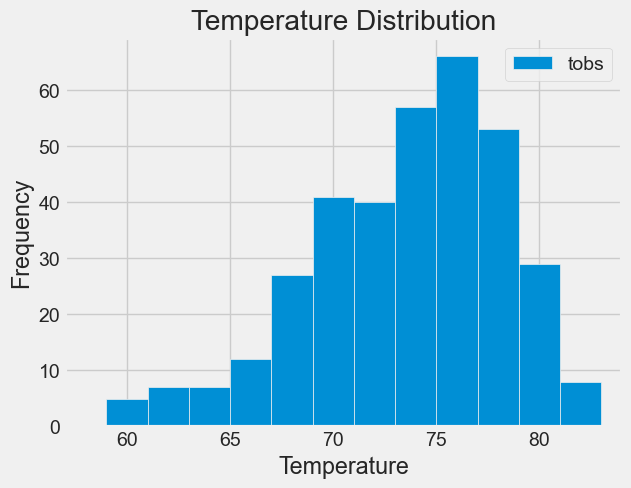

In [105]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Perform a query to retrieve the data and temperature data in last 12 months
temp_data = (
    session.query(Measurements.tobs)
    .filter(and_(
        Measurements.station == most_active_station,
        Measurements.date.between(previous_date, most_recent_date) 
    ))
    .all()
)

temp_df = pd.DataFrame(temp_data)

# Plot the histogram 
plt.figure(figsize=(12, 10))
temp_df.plot(kind='hist', y='tobs', bins=12, rwidth=1)
# sns.histplot(data=temp_df['tobs'], bins=12, kde=False,label='tobs') 
# Define the x-axis 
plt.xlim(57, 84)

# Title and Labels
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.legend(loc='best')
plt.show()


In [106]:
# Close Session
session.close()